# **Insurance: K-Means Clustering**        

## **Intro**

### It is time to move into the model building portion where we will train and test a k-means clustering model to analyze our dataset, but before we do that we want to provide you with some background on this algorithm. As you may have learned on Code Grands or elsewhere, there are broadly two different types of learning: `supervised` and `unsupervised`. `Supervised learning` is where we have an input and an expected output (labels) and the correct labels help guide the model towards improvement. A classic example is predicting patient diagnoses where we have symptoms (inputs) and historical diagnoses (outputs).

### Supervised leaning is great in the scenarios where you have data with labels and something you want to predict, but in some cases you only have input data with no labels but you still want to derive some kind of ujnderlying pattern or structure from it. IN this case, you would employ an unsupervised machine learning model, or one that learn patterns from your data in the absence of labels. K-Means clustering (and clustering in general) falls under the `unsupervised learning` category.

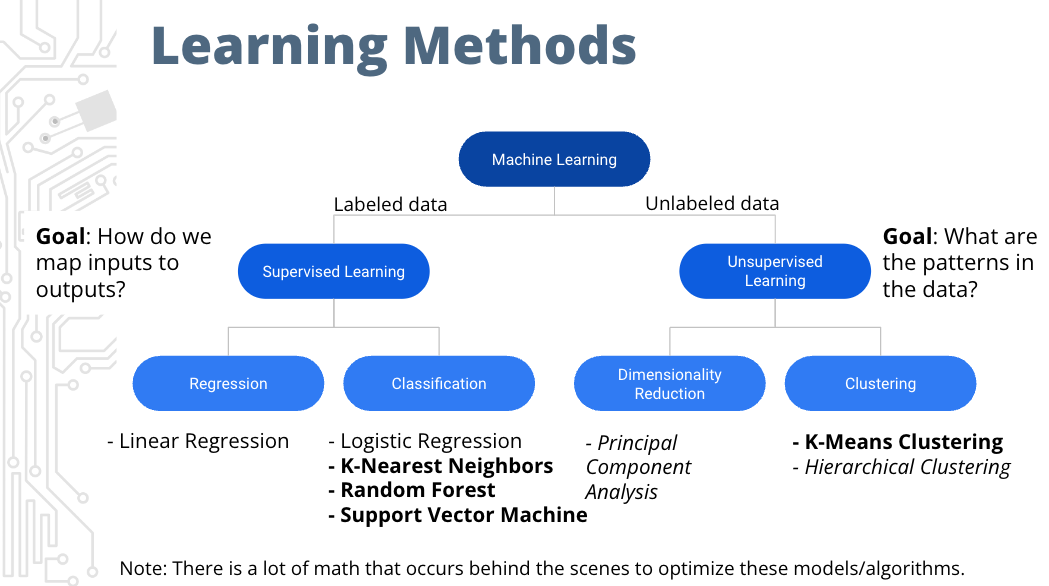

### Clustering is the process of grouping similar data points together based on certain features. At its core, clustering tries to ensure that data points in the same group are more like each other than those in other groups. Clustering your data can help you find patterns that you wouldn't be able to see by plotting, and it can help you summarize thousands of data points into discrete groups which aids all kind of downstream processes. Clustering our insurance dataset could help us understand different types of patients based off cost of insurance or various risk which may allow for more personalized care Although you must be very cautious when working with insurance data as you can accidentally build biased systems. Make sure you check out Module 7! In addition to this data, however, clustering is widely used all over medicine and basic science. One of the big use cases is in genomics (RNA-Seq), so if that is up your alley make sure you stay tuned!

### K-means clustering is an algorithm for clustering that divides a dataset into 'K' distinct, non-overlapping subsets (or clusters). What is 'K'? It signifies the number of clusters we believe exist in our dataset. The process of K-means clustering is very straightforward. Over your whole data set, you will first randomly select 'K' data points (not necessarily from the dataset) as initial centroids for the clusters. You will then Assign each data point to the nearest centroid (based on distance), and it becomes a member of that cluster. Once every point has been assigned to a cluster, you calculate the new mean (centroid) of each cluster and repeat the assignment and update steps until no improvements are made.

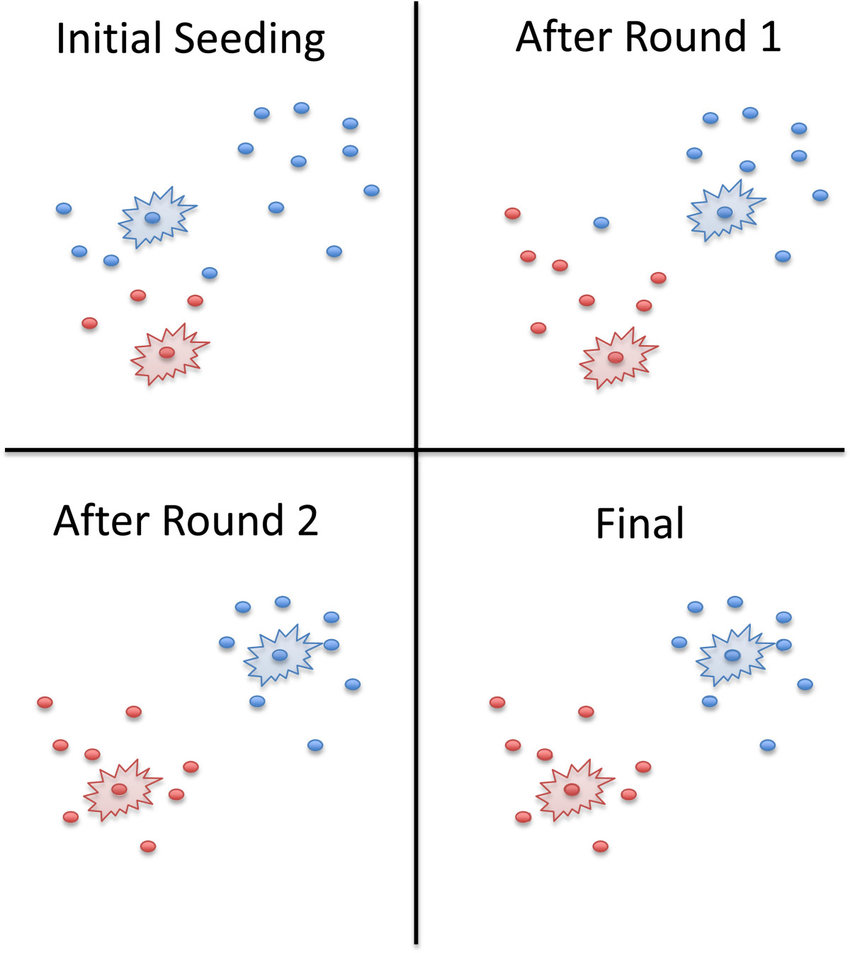
(devopedia)

### The nice thing about clustering, is that is it has a mathematical solution. As the whole point of the clustering algorithm is to iterate until it finds the `k` number of centroids that best partition your dataset into `k` clusters based on the distance of the points from the centroids, there exists a stable point for each cluster that will optimally separate your data. Once the clustering has finished you can evaluate how well it did based on examination of the centroids, the size distribution of the various cluster sizes, and some clustering specific metrics to evaluate the compactness. Without further ado, lets do some clustering!

### Import Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


### Import data and apply the same preprocessing as in the last notebook. Run this cell, but if you followed along in the data exploration section this code will all be the same 

In [ ]:
# Import the dataset
df = pd.read_csv('insurance.csv')
# Define the mapping dictionary
smoking_mapping = {'yes': 1, 'no': 0}

# Apply the mapping to the 'smoker' column
df['smoker'] = df['smoker'].map(smoking_mapping)

# Do one hot encoding
df_encoded = pd.get_dummies(df, columns=['sex', 'region'])

# convert true false to 1 or 0 using boolean logic
cols_to_convert = ['sex_female', 'sex_male', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
df_encoded[cols_to_convert] = df_encoded[cols_to_convert].astype(int)

## **Data Scaling**

### Now we are ready to start building our models. Before we actually do any clustering, we have to sit and think about what is actually happening in this algorithm as certain aspects of our data will play a crucial role in determining the efficacy of the algorithm. Firstly, for this exercise, we're focusing on the numerical features of our dataset: `age`, `bmi`, `children`, and `charges`. While we invested effort in converting our categorical data to numerical representations in the previous section, clustering is predominantly reliant on distances between data points. Including binary or one-hot encoded categorical data could introduce challenges in the distance computations, though there are ways to handle this in advanced scenarios. For the sake of clarity in this introduction, we'll focus on numerical data. However, remember that insights from categorical data, like the `smoker` feature, can still be leveraged to filter or group our clusters post-processing, much like we did with the pairplots previously.


### Another side effect of clustering algorithms relying on the distance between points is that they are very sensitive to the scale of features. If features have different scales, the feature with a larger scale may dominate the distance calculations. As a result, the clusters will form primarily based on that feature, potentially ignoring patterns from other, smaller-scale features. As such, before doing any clusteing we will scale our data using Z score standardization which will make the average of every feature 0 and the standard deviation 1. This will allow for a fair cluster to be calculated based on the distance. See Module 2 Logistic Regression where we have a more in depth discussion on Z-score standardization.

### Lets first scale our data using `StandardScaler` from `scikit-learn`

In [ ]:
# Make subset of the data that has a high range
df_numerical = df_encoded[['age','bmi', 'children', 'charges']]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data and transform it
df_scaled = scaler.fit_transform(df_numerical)

# Convert the scaled data back to a DataFrame for ease of use
df_scaled = pd.DataFrame(df_scaled, columns=df_numerical.columns)

# Display the first few rows to check the transformed data
print(df_scaled.head())

### Make a histogram and  check summary stats to make sure scaling worked 

In [ ]:
# Select only the columns wwe want to display from the DataFrame 'df' and make histograms
# # bins=20 means each individual histogram will have 20 bins.
df_scaled.hist(figsize=(10,10), bins=20)

# Adjust the padding between and around the subplots (histograms) for a cleaner look.
plt.tight_layout()

# Display the figure containing the histograms.
plt.show()

### The choice to scale children is not neccesarily the right one given the already low magnitude of this feature, but to keep things simple we scaled it here. In practice you might not do this, or better yet do clustering with and without scaling to see if it makes a difference.

### Now that we have scaled successfully, lets add back the data from our intial dataframe to our scaled one so we have access to all of our data before making models

In [ ]:
# Extract the columns that were not scaled from the original dataframe
df_not_scaled = df_encoded.drop(columns=['age', 'bmi', 'children', 'charges'])

# Concatenate the scaled and non-scaled dataframes along columns (axis=1)
df_combined = pd.concat([df_scaled, df_not_scaled], axis=1)

# Display the first few rows of the combined dataframe
print(df_combined.head())


### Alright! We are now ready to move into building some models using K-means clustering. Let first think about some of the questions we might want to ask that clustering could get the answer. 

### For things like insurance, perhaps we could start by trying to identify clusters of patients that are at higher risk based on the data we have access to (`smoking`, `bmi`, `age`). Lets start by trying to identify some risks groups based on insurance charges, age, and BMI. 

### We will first determine clusters between the `charges` and `BMI` features! Let's start by making the subset of our data we need for this

In [ ]:
# Subset the data to include bmi, charges, and smoker
df_risk =  df_combined[['bmi', 'charges', 'smoker']]

### Now lets perform the clustering. We will do this using the built in `KMeans` method from scikit-learn. All we have to do is define an initial value of `k`. Note: there are some more advanced ways to determine the optimal `k` based on your data (elbow plots). We won't go into that here, but know that choosing an appropriate value of k is very important and sometimes requires trial and error and testing of multiple values.

### Lets start with `k=5` just to get the ball rolling. You can play with this value to see how it affects the data

In [ ]:
# Instantiate an object of KMeans with k=5- feel free to play around with this!
kmeans = KMeans(n_clusters=5, random_state=42)

# Note: While fitting kmeans, ensure you only fit on the numerical columns 'bmi' and 'charges' 
df_risk['cluster'] = kmeans.fit_predict(df_risk[['bmi', 'charges']])

### None of that is really helpful without visualizing the clusters, so let's do that now! First, lets just visualize the clusters it calculated using the `hue` argument from seaborn- also feel free to go back and change the k value to see what happens to this graph!

In [ ]:
# Plot the data with the hue equal to the cluster column so we can see the distribution of clusters
sns.scatterplot(data=df_risk, x='charges', y='bmi', hue='cluster', palette='deep')
plt.title("Clusters based on Age and BMI")
plt.show()

In [ ]:
## For website- implementation in matplotlib

# Extract unique cluster labels and assign colors
clusters = df_risk['cluster'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(clusters)))

# Create a new plot
fig, ax = plt.subplots(figsize=(10, 7))

# Plot each cluster with different colors
for cluster, color in zip(clusters, colors):
    subset = df_risk[df_risk['cluster'] == cluster]
    # Using size to represent the smoking status
    ax.scatter(subset['charges'], subset['bmi'], color=color, 
               label=f'Cluster {cluster}')

# Setting labels, title and legend
ax.set_xlabel('Charges')
ax.set_ylabel('BMI')
ax.set_title("Clusters based on Charges and BMI with Smoking Status")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend to not overlap with plot

plt.show()


### Alright! Pretty cool. If you just did the data exploration notebook, however, you may remember looking at a graph similar to this when we made our pairplot. You also may remember that when we colored that graph by smoker status, we organically identified a subset of our patients that had high charges across any BMI range based on smoking status (if you needed a sign to always do data exploration this is it). Let's capitalize on the size of the dots in this plot to size them based on smoking 

In [ ]:
# Using size to represent the smoking status
sns.scatterplot(data=df_risk, x='charges', y='bmi', hue='cluster', size='smoker', sizes=(100, 20), palette='deep')
plt.title("Clusters based on Charges and BMI with Smoking Status")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend to not overlap with plot
plt.show()


In [ ]:
# implementation in matplotlib for website 
import matplotlib.pyplot as plt

# Define color palette based on unique clusters
clusters = df_risk['cluster'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(clusters)))

# Create a new plot
fig, ax = plt.subplots(figsize=(10, 7))

# Plot each cluster with different colors
for cluster, color in zip(clusters, colors):
    subset = df_risk[df_risk['cluster'] == cluster]
    subset_sizes = subset['smoker'].apply(lambda x: 100 if x == 1 else 20)
    ax.scatter(subset['charges'], subset['bmi'], color=color, s=subset_sizes, label=f'Cluster {cluster}')

# Add legend for smoking status using dummy scatter plots (for legend purposes only)
ax.scatter([], [], color='gray', s=100, label='Smoker')
ax.scatter([], [], color='gray', s=20, label='Non-Smoker')
smoker_legend = ax.legend(loc="upper right", title="Legend")

# Setting labels, title
ax.set_xlabel('Charges')
ax.set_ylabel('BMI')
ax.set_title("Clusters based on Charges and BMI with Smoking Status")

plt.show()



### So this is not surprising based on our intial data exploration, but still pretty cool how the clusters get created based on smoking status, so that could be a finding! Lets take this to the next level and add another dimension to the clustering.

### You can really cluster in any number of dimensions, but it gets harder to visualize after three due to running out of axes (remember you can always use size and color though- get creative!) 

### Lets add age into our clustering and see if that affects anything.

/Users/georgienahass/opt/anaconda3/envs/mnist/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/cy/r57v8qdj4f5_mg9q7pmcfbjr0000gn/T/ipykernel_89787/2296153388.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['cluster'] = kmeans.fit_predict(df_subset)


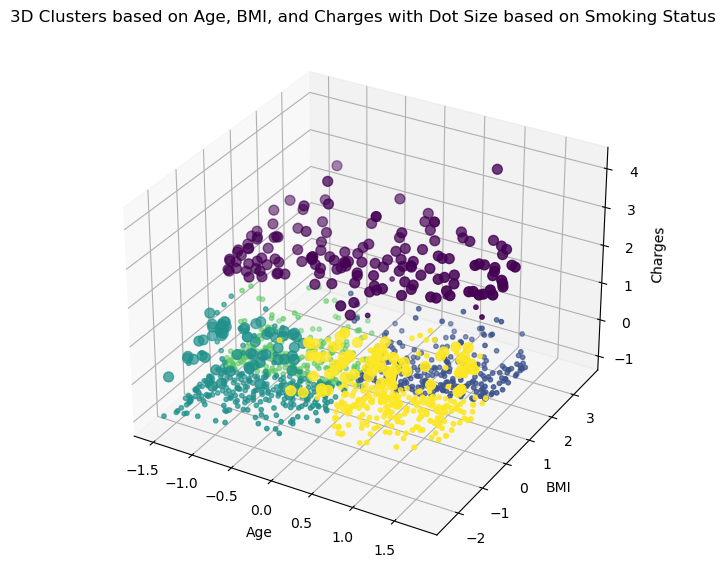

In [38]:
# Adding age to our subset
df_subset = df_combined[['bmi', 'charges', 'age', 'smoker']]

# K-means clustering using 5 cluster still - feel free to change
kmeans = KMeans(n_clusters=5)
df_subset['cluster'] = kmeans.fit_predict(df_subset)

# Define the dot sizes. For instance, larger size for smokers and smaller size for non-smokers
# Don't wory if this syntax is confusing. All it is doing is making size of dot for smokers larger
dot_sizes = np.where(df_subset['smoker'] == 1, 50, 10)


# 3D Visualization using matplotlib for 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_subset['age'], df_subset['bmi'], df_subset['charges'], c=df_subset['cluster'], s=dot_sizes, cmap='viridis')

# Setting axis labels
ax.set_xlabel('Age')
ax.set_ylabel('BMI')
ax.set_zlabel('Charges')

plt.title("3D Clusters based on Age, BMI, and Charges with Dot Size based on Smoking Status")
plt.show()


### Awesome. This seems to further the hypothesis that people that are smokers, regardless of `BMI` or `age ` have higher insurance costs as there is a clear cluster at the top of the graph that has high charges with the big dot size denoting they are smokers. There is of course, many more layers of insight you could pull out of this data. You could experiment with some feature engineering (e.g., multiplying age by bmi to create a new feature), different number of clusters, different visualization techniques, etc, but we will leave that to you. 

### There is also a lot we didn't touch on here like calculating the size of the clusters and different methods to choose the best K (silouhette scores and elbow plots being the two main ones) as that is a much longer discussion, but we encourage you to read up on that before implementing this algorithm in your work as those factors are very important features to squeeze the most out of k-means. All that being said, we hope you enjoyed this notebook! We will see you in the next project on Random Forests!